In [2]:
from music21 import converter, instrument, note, chord, stream
from keras.layers import Embedding, Dense, Dropout, LSTM, Activation, Lambda, Input
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def convolve(x,h):
    result = signal.convolve(x,h)
    return result

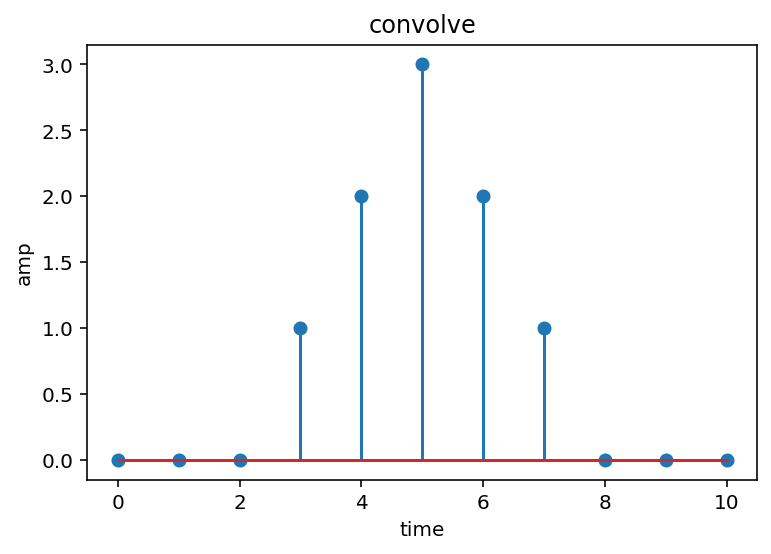

In [4]:
x = [0,0,1,1,1,0]
h = [0,1,1,1,0,0]
g=np.arange(2*len(h)-1)
y = convolve(x,h)
plt.title("convolve")
plt.xlabel("time")
plt.ylabel("amp")
plt.stem(g, y)
plt.show()

In [20]:
dataset_name = 'data'
filename = 'DreamOn'
file = "./{}/{}.mid".format(dataset_name, filename)

original_score = converter.parse(file).chordify()

In [21]:
notes = []
durations = []

for element in original_score.flat:
    if isinstance(element, chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)
    
    if isinstance(element, note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)
            

In [27]:
notes_in = Input(shape = (None,))
durations_in = Input(shape = (None,))


x1 = Embedding(n_notes, embed_size)(notes_in)
x2 = Embedding(n_durations, embed_size)(durations_in)

x = Concatenate()([x1,x2])

x = LSTM(rnn_units, return_sequences = True)(x)
x = LSTM(rnn_units, return_sequences = True)(x)

e = Dense(1, activation='tanh')(x)
e = Reshape([-1])(e)

alpha = Activation('softmax')(e)

c = Permute([2,1])(RepeatVector(rnn_units)(alpha))
c = Multiply()([x,c])
c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)

notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)

model = Model([notes_in, durations_in], [notes_out, durations_out])

att_model = Model([notes_in, durations_in], alpha)

opti = RMSprop(lr = 0.001)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)

NameError: name 'n_notes' is not defined